In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Работа с данными 
import pandas as pd
import numpy as np

# Балансировка
from imblearn.over_sampling import SMOTE

# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Классификаторы
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

# Оценка качества
from yellowbrick.classifier import ROCAUC
from catboost.utils import get_confusion_matrix
from yellowbrick.contrib.wrapper import wrap

# Визуалцияция результатов обучения
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt

#Заполнение пропусков
from sklearn.impute import SimpleImputer

#1.Загрузка массива целей

## 1.1. Загрузите массив целей

In [4]:
#Загрузка массива целей
goal_cipher = pd.read_csv(r'/content/drive/MyDrive/goal_cipher.csv')
goal_cipher.head()

,Unnamed: 0,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
1,3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
2,4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
3,7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
4,9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


In [5]:
#Загрузка массива признаков
data = pd.read_csv(r'/content/drive/MyDrive/feature_data_new_mini.csv')
data.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (113,116,119,122,125) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07-28,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


###Чистка данных

In [6]:
#Удаление дубликатов из массива признаков
print(len(data.index))
data = data.drop_duplicates()
print(len(data.index))

167254
165691


### Сравнение дата-сетов

In [7]:
data.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07-28,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


In [8]:
goal_cipher.head()

,Unnamed: 0,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
1,3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
2,4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
3,7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
4,9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


### 1.2.	Сформируете новый массив из feature_data_new_mini.csv по соответствующему столбцу и названию фрукта 

In [9]:
#Выделение названия фрукта по соответствующему столбцу 
goal_cipher = goal_cipher[goal_cipher['fail_place'] == 'Гуайява обыкновенная']

### Готовим данные к объединению

In [10]:
#Преобразование массива goal_cipher, путем удаления ненужных столбцов:
#fail_place; fail_reason; fail_type
goal_cipher = goal_cipher[['ser_loc','zns_loc','prs_loc','year_month', 'day']]
print(goal_cipher)

#Перевод названий колонок в нижний регистр
goal_cipher.columns = [x.lower() for x in goal_cipher.columns]

#Преобразования типов данных в int() в столбце day
goal_cipher['day'] = [int(x) for x in goal_cipher['day']]
data.head()

#Обработка данных типа date() в столбце year_month
data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
goal_cipher['year_month'] = pd.to_datetime(goal_cipher['year_month'], format='%Y-%m')

data['year_month'] = data['year_month'].dt.to_period('M')
goal_cipher['year_month'] = goal_cipher['year_month'].dt.to_period('M')

data.head()
goal_cipher.head()

       ser_loc  zns_loc  prs_loc year_month  day
25         240   1634.0      1.0    2021-01   15
26         240    141.0      1.0    2021-01    1
44         233   1541.0      1.0    2021-01   13
45         145    167.0      1.0    2021-01   17
47         244    158.0      1.0    2021-01    1
...        ...      ...      ...        ...  ...
49917      234     59.0      0.0    2019-11   21
50081      244    117.0      1.0    2019-11   23
50128      244    215.0      2.0    2019-11   18
51743      134    374.0      2.0    2018-06   30
52759      123    571.0      1.0    2018-09   24

[1343 rows x 5 columns]


<ipython-input-10-c05ec94a836d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_cipher['day'] = [int(x) for x in goal_cipher['day']]
<ipython-input-10-c05ec94a836d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_cipher['year_month'] = pd.to_datetime(goal_cipher['year_month'], format='%Y-%m')
<ipython-input-10-c05ec94a836d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,ser_loc,zns_loc,prs_loc,year_month,day
25,240,1634.0,1.0,2021-01,15
26,240,141.0,1.0,2021-01,1
44,233,1541.0,1.0,2021-01,13
45,145,167.0,1.0,2021-01,17
47,244,158.0,1.0,2021-01,1


##1.3. Проверка размера массива

In [11]:
len(goal_cipher.index)

1343

#2.Объединения массива целей с массивом признаков

In [12]:
#Объединение массивов goal_cipher(целей) и data(признаков) в новый массив data_new
data_new = data.merge(goal_cipher, on = ['ser_loc','zns_loc','prs_loc','year_month'], how = 'outer')

Поиск и чистка плохих столбцов

In [13]:
data_new = data_new.dropna(subset = ['count_fail'])

In [14]:
i = 0
for col_name in data.columns:
    if col_name.find('_x_') == True:
        print(i)
    i += 1 

In [15]:
data_new = data_new.drop(columns=['date_repair_finish_y_1',
       'date_repair_finish_x_2',
       'date_repair_finish_y_2', 'date_repair_finish', 
       'date_repair_finish_x_1'])

# 3.Выполнить обработку пропусков после объединения. Обосновать замену или удаления пропусков.

In [16]:
data_new['day']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
165692   NaN
165693   NaN
165694   NaN
165695   NaN
165696   NaN
Name: day, Length: 165697, dtype: float64

In [17]:
#заполнение пропусков в столбце day нулями, если данные есть то единицы
data_new['day'] = [1 if x > 0 else 0 for x in data_new['day']]


#4.Выбрать метод обучения: регрессия или классификация.

## Подготовка данных к классификации

#5.Исходя из выбранного методы преобразовать целевые метки.

## 5.2. Если в качестве метода обучения выбирается классификатор, то возможны следующие стратегии дискретизации:

## 5.2.2.	1 – отказ в первой половине месяца, 0 – во второй.

In [18]:
#Если день не NaN, то он становится 1, иначе 0
data_new['day'] = [1 if x > 0 else 0 for x in data_new['day']]

In [19]:
data_new['day'].value_counts()

0    165629
1        68
Name: day, dtype: int64

#6.Инженерия данных

In [22]:
#Направление ser_loc,  zns_loc, prs_loc в индексы
data_new = data_new.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

In [23]:
data_new

count_fail  107_repair_count  \
ser_loc zns_loc prs_loc year_month                                 
107     3.0     1.0     2020-01            1.0               0.0   
                        2019-03            1.0               0.0   
        4.0     1.0     2020-04            1.0               0.0   
                        2020-06            1.0               0.0   
                        2020-07            1.0               0.0   
...                                        ...               ...   
693     74.0    3.0     2019-03            0.0               0.0   
                        2021-04            0.0               0.0   
                        2021-05            0.0               0.0   
                        2021-07            0.0               0.0   
                        2021-10            0.0               0.0   

                                    307_repair_count  308_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               0.0   
                        2020-06                  0.0               0.0   
                        2020-07                  0.0               1.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    309_repair_count  521_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               0.0   
                        2020-06                  0.0               0.0   
                        2020-07                  0.0               0.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    800_repair_count  801_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               1.0   
                        2020-06                  0.0               1.0   
                        2020-07                  0.0               0.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    автоматический перевод в нр при превышении норм на то-2  \
ser_loc zns_loc prs_loc year_month                                                            
107     3.0     1.0     2020-01                                         

Нормирование данных

In [24]:
#Нормирование данных
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(data_new) 
data_new = pd.DataFrame(arr_scaled, columns=data_new.columns,index=data_new.index)

In [25]:
data_new

count_fail  107_repair_count  \
ser_loc zns_loc prs_loc year_month                                 
107     3.0     1.0     2020-01       0.142857               0.0   
                        2019-03       0.142857               0.0   
        4.0     1.0     2020-04       0.142857               0.0   
                        2020-06       0.142857               0.0   
                        2020-07       0.142857               0.0   
...                                        ...               ...   
693     74.0    3.0     2019-03       0.000000               0.0   
                        2021-04       0.000000               0.0   
                        2021-05       0.000000               0.0   
                        2021-07       0.000000               0.0   
                        2021-10       0.000000               0.0   

                                    307_repair_count  308_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0          0.000000   
                        2019-03                  0.0          0.000000   
        4.0     1.0     2020-04                  0.0          0.000000   
                        2020-06                  0.0          0.000000   
                        2020-07                  0.0          0.076923   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0          0.000000   
                        2021-04                  0.0          0.000000   
                        2021-05                  0.0          0.000000   
                        2021-07                  0.0          0.000000   
                        2021-10                  0.0          0.000000   

                                    309_repair_count  521_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               0.0   
                        2020-06                  0.0               0.0   
                        2020-07                  0.0               0.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    800_repair_count  801_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0          0.000000   
                        2019-03                  0.0          0.000000   
        4.0     1.0     2020-04                  0.0          0.166667   
                        2020-06                  0.0          0.166667   
                        2020-07                  0.0          0.000000   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0          0.000000   
                        2021-04                  0.0          0.000000   
                        2021-05                  0.0          0.000000   
                        2021-07                  0.0          0.000000   
                        2021-10                  0.0          0.000000   

                                    автоматический перевод в нр при превышении норм на то-2  \
ser_loc zns_loc prs_loc year_month                                                            
107     3.0     1.0     2020-01                                         

Тут балансировка данных необходима, так как слишком большая разница в количестве значений

In [26]:
#Разделим набор данных на признаки и метки
y = data_new[['day']]
X = data_new.drop(columns=['day'])

In [27]:
#Заполнение пустых полей NaN средними значениями
#Чтобы при балансровке не выдавало ошибку
X = X.fillna(X.mean())

###6.4. Разделите ваш массив на обучающую и тестовую выборку.

In [28]:
#Балансировка данных
sm = SMOTE(random_state=42, k_neighbors=5)

X_res, y_res = sm.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

<ipython-input-28-6ed439e77a13>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


array([[33188,     6],
       [   21, 33037]])

#7.Обучение моделей

## CatBoostClassifier

In [29]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

In [30]:
clf.fit(X_train, y_train,         
        eval_set=(X_test, y_test), 
        verbose=False
)

#8.Проверка качества

##8.1. Напишите собственную функцию для проверки качества.

In [31]:
X_test = X_test.fillna(X_train.mean())

In [32]:
cm = get_confusion_matrix(clf, Pool(np.array(X_train), np.array(y_train)))
cm

array([[120024.,  12411.],
       [  8273., 124298.]])

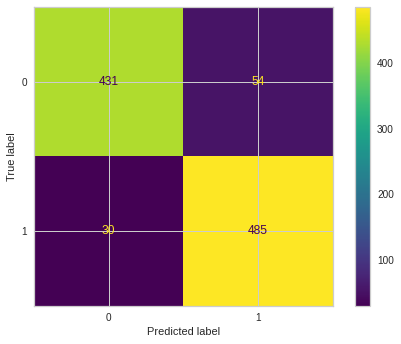

In [33]:
cmm = confusion_matrix(y_test[:1000], clf.predict(X_test[:1000]), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmm,
                              display_labels=clf.classes_)

disp.plot()
plt.show()

In [34]:
def acc(conf_matrix):
  TP=conf_matrix[0][0]
  FN=conf_matrix[1][0]
  FP=conf_matrix[0][1]
  TN=conf_matrix[1][1]
  accuracy_1=(TP+TN)/(TP+FN+FP+TN)

  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  f=(2*precision*recall)/(precision+recall)

  b=0.1
  fb=((1+b**2)*precision*recall)/((b**2*precision)+recall)

  print(f'Оценка Accuracy: {accuracy_1}\nОценка F-мера: {f}\nОценка F-мера с весом точности {b}: {fb}')
  
acc(cmm)

Оценка Accuracy: 0.916
Оценка F-мера: 0.9112050739957717
Оценка F-мера с весом точности 0.1: 0.889095402463185


##8.2. Сравните встроенные функции проверки качества с вашими.

In [35]:
train_score = clf.score(X_train, y_train) # train (learn) score
train_score

0.9219489370051999

In [36]:
val_score = clf.score(X_test, y_test) # val (test) score
val_score

0.9199722272535169